- Make sure that you get new data first (fetch_coinapi.ipynb)
- Make sure to update the index (create_index.ipynb)

In [28]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import time
import coinbase_reader
from matplotlib import pyplot as plt
import backtest
import simple_regression
import numpy as np
import ledoit_wolf
from pypfopt import HRPOpt, expected_returns, risk_models

In [29]:
index = pd.read_csv('./index.csv', index_col=0, parse_dates=True)
index.name = 'value'
print(f'Got index with length {len(index)}')

Got index with length 3914


100%|██████████| 1/1 [00:00<00:00, 20.69it/s]

Stat                 benchmark
-------------------  -----------
Start                2015-01-14
End                  2025-10-13
Risk-free rate       0.00%

Total Return         45130.50%
Daily Sharpe         0.95
Daily Sortino        1.63
CAGR                 76.65%
Max Drawdown         -86.99%
Calmar Ratio         0.88

MTD                  0.54%
3m                   -1.31%
6m                   36.45%
YTD                  24.31%
1Y                   81.88%
3Y (ann.)            80.84%
5Y (ann.)            39.15%
10Y (ann.)           71.74%
Since Incep. (ann.)  76.65%

Daily Sharpe         0.95
Daily Sortino        1.63
Daily Mean (ann.)    57.34%
Daily Vol (ann.)     60.46%
Daily Skew           1.38
Daily Kurt           32.19
Best Day             68.30%
Worst Day            -38.86%

Monthly Sharpe       1.04
Monthly Sortino      2.44
Monthly Mean (ann.)  77.70%
Monthly Vol (ann.)   74.52%
Monthly Skew         0.48
Monthly Kurt         0.43
Best Month           70.50%
Worst Month       

<Axes: title={'center': 'Equity Progression'}>

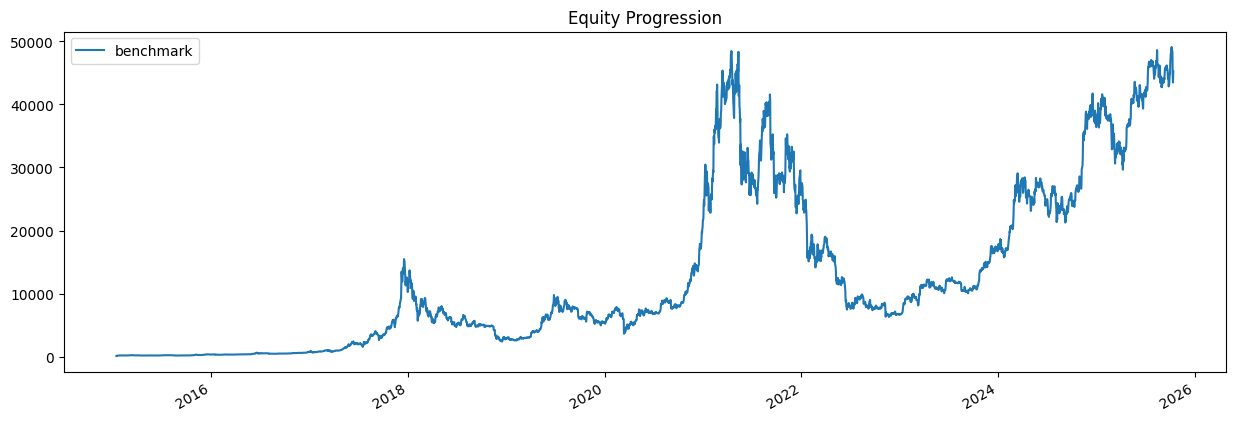

In [30]:
# Benchmark: Our index
import bt
strategy = bt.Strategy(
    'benchmark',
    [
        bt.algos.RunOnce(),
        bt.algos.SelectAll(),
        bt.algos.WeighEqually(),
        bt.algos.Rebalance(),
    ],
)
test = bt.Backtest(strategy, index, initial_capital=100000)
result = bt.run(test)
result.display()
result.plot()

In [31]:
# The paper below favors 28 days as a lookback period and a 5-day holding period. Adding longer
# periods just takes more time, but does not improve the result.
lookback_periods = [10, 20, 30, 45, 60, 75]
index_cagrs = [
    index.rolling(window=lb).apply(simple_regression.create_regression('cagr'))
    for lb in lookback_periods
]
# index_r2s = [
#     index.rolling(window=lb).apply(simple_regression.create_regression('r2'))
#     for lb in lookback_periods
# ]

/Users/fs/Documents/Aktien/Code/Python/2025-04-crypto/.venv/lib/python3.12/site-packages/sklearn/linear_model/_theil_sen.py:127: ConvergenceWarning: Maximum number of iterations 300 reached in spatial median for TheilSen regressor.
  warnings.warn(
/Users/fs/Documents/Aktien/Code/Python/2025-04-crypto/.venv/lib/python3.12/site-packages/sklearn/linear_model/_theil_sen.py:127: ConvergenceWarning: Maximum number of iterations 300 reached in spatial median for TheilSen regressor.
  warnings.warn(
/Users/fs/Documents/Aktien/Code/Python/2025-04-crypto/.venv/lib/python3.12/site-packages/sklearn/linear_model/_theil_sen.py:127: ConvergenceWarning: Maximum number of iterations 300 reached in spatial median for TheilSen regressor.
  warnings.warn(


Go long:
                           value
date                            
2015-04-06 00:00:00+00:00      0
2015-04-13 00:00:00+00:00      0
2015-04-20 00:00:00+00:00      0
2015-04-27 00:00:00+00:00      0
2015-05-04 00:00:00+00:00      0
...                          ...
2025-09-15 00:00:00+00:00      0
2025-09-22 00:00:00+00:00      0
2025-09-29 00:00:00+00:00      0
2025-10-06 00:00:00+00:00      1
2025-10-13 00:00:00+00:00      0

[547 rows x 1 columns]


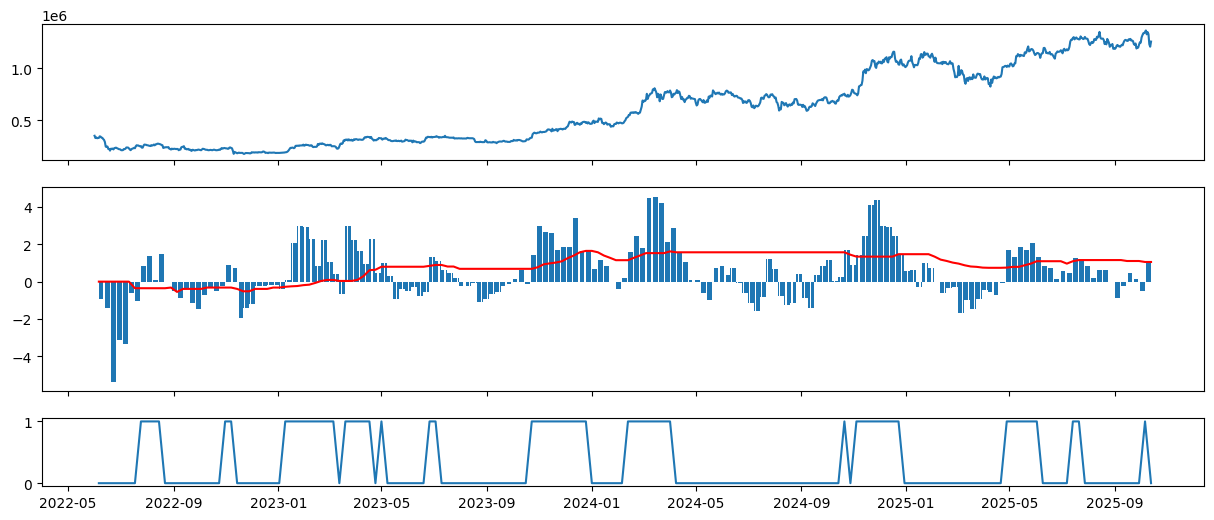

Mean CAGRs - best percentile
We go long if > 0 (and if mean CAGR is > 0)
                              value
date                               
2025-08-11 00:00:00+00:00 -0.510398
2025-08-18 00:00:00+00:00 -0.542633
2025-08-25 00:00:00+00:00 -1.192602
2025-09-01 00:00:00+00:00 -2.037292
2025-09-08 00:00:00+00:00 -1.372018
2025-09-15 00:00:00+00:00 -0.655390
2025-09-22 00:00:00+00:00 -0.964107
2025-09-29 00:00:00+00:00 -1.624041
2025-10-06 00:00:00+00:00  0.029954
2025-10-13 00:00:00+00:00 -0.901456


In [32]:
# Get the mean for the CAGRs and decide when we should go long
mean_cagrs = sum(index_cagrs[:]) / len(index_cagrs[:])
# Only preserve the cells in which there's cagr data for *all* lookback periods (period 10 has
# more data than 75 because the window starts earlier) – use the last lookback period as mask.
mean_cagrs = mean_cagrs[index_cagrs[-1].notna()]
# Terribly dangerous: Never bfill; this would apply future's knowledge to today's data. Always
# ffill (newer dates are lower down in our df)
# Drop all weekdays without data
cleaned_mean_cagrs = mean_cagrs.dropna()

# binary = [np.sign(df).dropna() for df in index_cagrs]
# binary_sum = sum(binary)
# binary_long = binary_sum >= len(lookback_periods)
# print(f'Binary long: {len(binary_long[binary_long].dropna())}')

# Adding r2 does not improve anything
# mean_r2s = sum(index_r2s) / len(index_r2s)
# mean_r2s = mean_r2s[index_r2s[-1].notna()].dropna()

# Go long when cagr is in the top third (compared to the past)
# Inspiration: https://acfr.aut.ac.nz/__data/assets/pdf_file/0009/918729/Time_Series_and_Cross_Sectional_Momentum_in_the_Cryptocurrency_Market_with_IA.pdf
# q67 = cleaned_mean_cagrs.expanding().quantile(0.75)
# Don't look back too far: If the past was too good, there won't be any positions in the future. 
# 100 equals 2 years as we have weekly data (100 weeks = 700 days = 2 years)
best_percent = cleaned_mean_cagrs.rolling(window=50).quantile(2/3)

# Also make sure that values are above/below 0, do not just use the relative ranking.
# Adding r2 (e.g. > 0 or > 0.5) does not improve anything.
is_top = (cleaned_mean_cagrs >= best_percent) & (cleaned_mean_cagrs > 0)
# Buying on growing CAGR does not improve anything
# & (cleaned_mean_cagrs > cleaned_mean_cagrs.shift(1))
go_long = is_top.astype(int)

print('Go long:')
print(go_long)

fig, ax = plt.subplots(3, 1,figsize=(15, 6), sharex=True, gridspec_kw={'height_ratios': [2, 3, 1]})
start = '2022-06-01'
end = None
ax[0].plot(index.loc[start:end])
cagrs_to_plot = cleaned_mean_cagrs['value']
cagrs_to_plot = cagrs_to_plot.loc[start:end].reindex(index.loc[start:end].index).ffill()
ax[1].bar(cagrs_to_plot.index, cagrs_to_plot.values)
ax[1].plot(best_percent[start:end], color='red')
ax[2].plot(go_long.loc[start:end])
plt.show()

print('Mean CAGRs - best percentile\nWe go long if > 0 (and if mean CAGR is > 0)')
print((cleaned_mean_cagrs - best_percent).iloc[-10:])

100%|██████████| 1/1 [00:00<00:00,  7.95it/s]


Stat                 ledoit_wolf
-------------------  -------------
Start                2015-01-14
End                  2025-10-13
Risk-free rate       0.00%

Total Return         10149.11%
Daily Sharpe         1.11
Daily Sortino        1.80
CAGR                 53.85%
Max Drawdown         -38.11%
Calmar Ratio         1.41

MTD                  -6.76%
3m                   -6.06%
6m                   5.50%
YTD                  5.50%
1Y                   38.62%
3Y (ann.)            37.38%
5Y (ann.)            55.60%
10Y (ann.)           58.87%
Since Incep. (ann.)  53.85%

Daily Sharpe         1.11
Daily Sortino        1.80
Daily Mean (ann.)    34.72%
Daily Vol (ann.)     31.38%
Daily Skew           0.66
Daily Kurt           16.36
Best Day             19.12%
Worst Day            -15.19%

Monthly Sharpe       1.16
Monthly Sortino      4.23
Monthly Mean (ann.)  52.30%
Monthly Vol (ann.)   45.17%
Monthly Skew         2.12
Monthly Kurt         5.38
Best Month           57.12%
Worst Month    

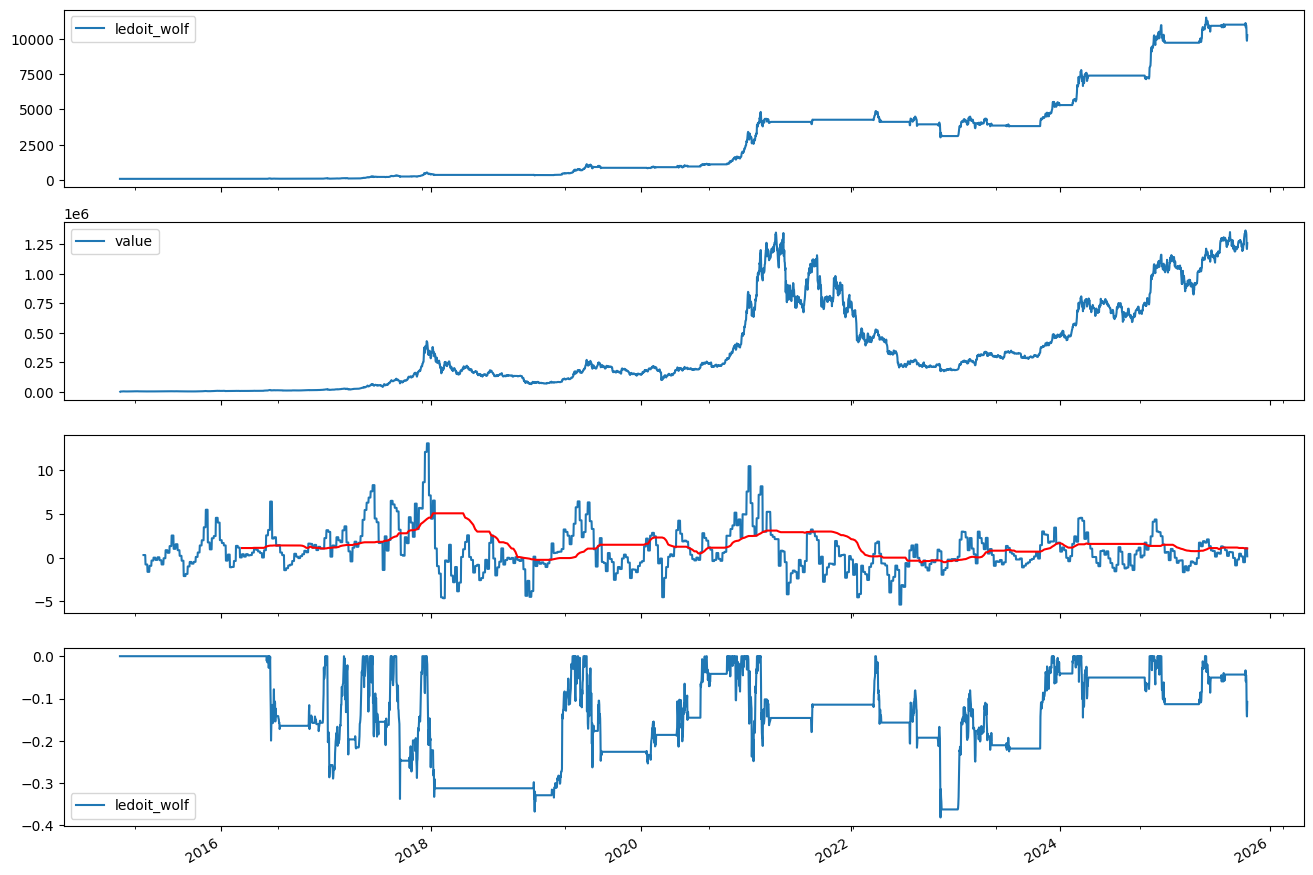

In [33]:
# See how we'd perform if we held the index on good times (top CAGR periods)
index_result = backtest.run('ledoit_wolf', index, go_long)
index_result.display()

index_rolling_max = index_result.prices.cummax()
index_drawdowns = (index_result.prices - index_rolling_max) / index_rolling_max

fig, ax = plt.subplots(4, 1,figsize=(16, 12), sharex=True)
index_result.prices.plot(ax=ax[0])
index.plot(ax=ax[1])
# ax[1].bar(mean_cagrs['value'].index, mean_cagrs['value'].values)
ax[2].plot(mean_cagrs.ffill())
ax[2].plot(best_percent, color='red')
index_drawdowns.plot(ax=ax[3])
plt.show()

In [34]:
# Calculate CAGR / R2 for all index constituents

index_weights = pd.read_csv('index_weights.csv', index_col=0)
# Drop all cols that dont belong to the index
index_weights = index_weights.dropna(axis=1, how='all')
constituent_names = index_weights.columns.to_list()
print(f'{len(constituent_names)} index constituents are {constituent_names}')

data_dir = '../coinapi_data/historical/'
closes = coinbase_reader.read('close')
constituent_closes = closes[constituent_names]

print(f'Use {len(constituent_closes.columns)} cryptos with {len(closes)} rows')

# For simple experiments, limit our dataset
# lookback_periods = [75]
# constituent_closes = closes[['ETH']]

constituent_cagrs = []
constituent_r2s = []
for lb in lookback_periods:
    start_time = time.time()
    print(f'Starting lookback period {lb} …')
    constituent_cagrs.append(
        constituent_closes.rolling(window=lb).apply(simple_regression.create_regression('cagr'))
    )
    # constituent_r2s.append(
    #     constituent_closes.rolling(window=lb).apply(simple_regression.create_regression('r2'))
    # )
    print(f'Lookback period {lb} done after {round(time.time() - start_time)} seconds')

76 index constituents are ['AAVE', 'ACH', 'ADA', 'AERO', 'ALGO', 'AMP', 'ANKR', 'APE', 'ARB', 'ATOM', 'AVAX', 'BAND', 'BCH', 'BONK', 'BTC', 'CGLD', 'COMP', 'CRO', 'CRV', 'DASH', 'DOGE', 'DOT', 'ENJ', 'EOS', 'ETC', 'ETH', 'FET', 'FIL', 'GALA', 'GRT', 'HBAR', 'ICP', 'INJ', 'JASMY', 'KNC', 'LINK', 'LRC', 'LTC', 'MANA', 'MATIC', 'MKR', 'MOODENG', 'NEAR', 'NMR', 'NU', 'OMG', 'ONDO', 'OPTIM', 'OXT', 'PENGU', 'PEPE', 'QNT', 'REN', 'REP', 'RNDR', 'SEI', 'SHIB', 'SKL', 'SNX', 'SOL', 'STORJ', 'STX', 'SUI', 'SUSHI', 'TIA', 'TRUMP', 'UNI', 'WIF', 'WLUNA', 'XCN', 'XLM', 'XRP', 'XTZ', 'YFI', 'ZEC', 'ZRX']
Use 76 cryptos with 3914 rows
Starting lookback period 10 …


/Users/fs/Documents/Aktien/Code/Python/2025-04-crypto/.venv/lib/python3.12/site-packages/sklearn/linear_model/_theil_sen.py:127: ConvergenceWarning: Maximum number of iterations 300 reached in spatial median for TheilSen regressor.
  warnings.warn(


Lookback period 10 done after 14 seconds
Starting lookback period 20 …
Lookback period 20 done after 22 seconds
Starting lookback period 30 …


/Users/fs/Documents/Aktien/Code/Python/2025-04-crypto/.venv/lib/python3.12/site-packages/sklearn/linear_model/_theil_sen.py:127: ConvergenceWarning: Maximum number of iterations 300 reached in spatial median for TheilSen regressor.
  warnings.warn(


Lookback period 30 done after 35 seconds
Starting lookback period 45 …
Lookback period 45 done after 64 seconds
Starting lookback period 60 …
Lookback period 60 done after 107 seconds
Starting lookback period 75 …
Lookback period 75 done after 164 seconds


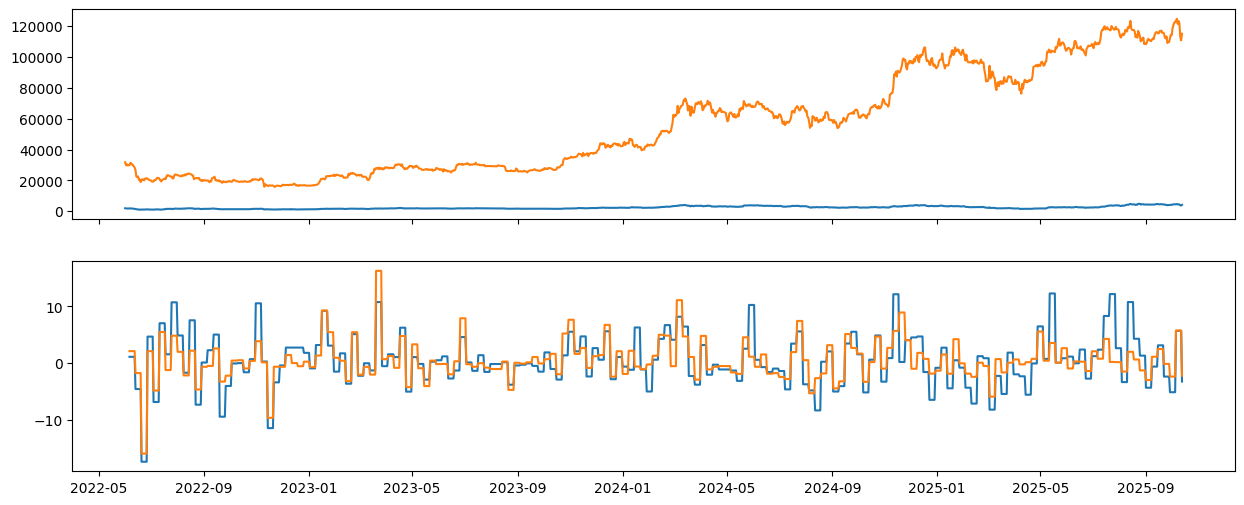

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(15, 6), sharex=True)
ax[0].plot(constituent_closes[['ETH', 'BTC']].loc[start:end])
ax[1].plot(constituent_cagrs[0][['ETH', 'BTC']].loc[start:end].ffill())
plt.show()

In [ ]:
# With lookback period 10, we have more data than with lookback period 75. Why? Because we can
# start our calculations earlier (after 10 rows of non-nan data). Make sure we only preserve cells
# that have data in *all* lookback periods.
cagr_mask = np.logical_and.reduce([~df.isna() for df in constituent_cagrs])
# Apply the mask to each df
cleaned_constituent_cagrs = [df.where(cagr_mask) for df in constituent_cagrs]
mean_constituent_cagrs = sum(cleaned_constituent_cagrs[:-2]) / len(cleaned_constituent_cagrs[:-2])
mean_constituent_cagrs = mean_constituent_cagrs.dropna(how='all')

# r2_mask = np.logical_and.reduce([~df.isna() for df in constituent_r2s])
# cleaned_constituent_r2s = [df.where(r2_mask) for df in constituent_r2s]
# mean_constituent_r2s = sum(cleaned_constituent_r2s) / len(cleaned_constituent_r2s)
# mean_constituent_r2s = mean_constituent_r2s.dropna(how='all')

# Create default weights table with value 0
weights = pd.DataFrame(index=go_long.index, columns=constituent_names)
weights[:] = 0

# Window of 50 = 1 year lookback
# crypto_percentiles = mean_constituent_cagrs.rolling(window=100).quantile(0.75)

# up_cagrs = mean_constituent_cagrs > mean_constituent_cagrs.shift(1)

# Whenever the index tells us to go long, get the best performing cryptos (that are part of the
# index) at that time. 
# go_long is a df, we only need the first column (therefore the brackets).
for date, [is_long] in go_long.iterrows():
    if is_long == 1:
        # Get the best performing cryptos
        current_cagrs = mean_constituent_cagrs.loc[date]
        # current_cagrs = current_cagrs[up_cagrs.loc[date]]

        # current_r2s = mean_constituent_r2s.loc[date]
        # current_cagrs = current_cagrs[current_r2s > 0]
        # top_cagrs = current_cagrs[current_cagrs > crypto_percentiles.loc[date]]
        best_cryptos = current_cagrs.sort_values(ascending=False)

        best_cryptos = best_cryptos.dropna()
        # Remove all cryptos with a cagr < x; why x=2? Because it works well.
        best_cryptos = best_cryptos[best_cryptos > 2]
        best_cryptos = best_cryptos[:10]
        # Reduce weights of single instruments
        # best_cryptos = best_cryptos ** 0.5
        # Equal weights
        # best_cryptos[:] = 1
        # Normalize to sum of 1
        # print(f'Best performing on {date.date()}: {best_cryptos.to_dict()}')

        ledoit_period = pd.Timedelta(days=100)
        data_for_ledoit = constituent_closes.loc[date-ledoit_period:date, best_cryptos.index]

        ledoit_weights = ledoit_wolf.calculate_weights(data_for_ledoit)
        # print('Max Div', best_cryptos.index.to_list(), ledoit_weights)

        # changes = data_for_ledoit.pct_change().dropna()
        # cov_matrix_lw = risk_models.CovarianceShrinkage(data_for_ledoit).ledoit_wolf()

        # if (len(changes.columns) == 1):
        #     hrp_weights = [1]
        # else:
        #     hrp = HRPOpt(returns=changes, cov_matrix=cov_matrix_lw)
            # HRP.optimize returns an OrderedDict; just get the list of values.
        #     hrp_weights = list(hrp.optimize().values())
        # print('HRP', best_cryptos.index.to_list(), hrp_weights)

        # You can drop in hrp_weights here – but it does not improve anything
        weights.loc[date, best_cryptos.index] = ledoit_weights

        # best_cryptos = best_cryptos / best_cryptos.sum()
        # weights.loc[date, best_cryptos.index] = best_cryptos.values

# No weight over 25%, ever
# Does not improve anything.
# weights[weights > 0.2] = 0.2

weights.to_csv('weights.csv')

weights.plot(figsize=(16, 4), legend=False)
plt.show()

last_weights = weights[-50:]
last_weights.index = last_weights.index.date
# Drop all cols only containing 0
last_weights = last_weights.loc[:, (last_weights != 0).any(axis=0)]
last_weights.plot(kind='bar', stacked=True, figsize=(16, 4), legend=False)
plt.show()

NameError: name 'np' is not defined

In [ ]:
# Make very sure that we have weights on all dates that we could trade because there's date to 
# do so.
# Terribly dangerous: Never bfill; this would apply future's knowledge to today's data. Always
# ffill (newer dates are lower down in our df)
weights = weights.reindex(constituent_closes.index).ffill().fillna(0)
constituent_closes = constituent_closes.ffill()

result = backtest.run('trend_following_index', constituent_closes, weights)
result.display()

rolling_max = result.prices.cummax()
drawdowns = (result.prices - rolling_max) / rolling_max
print('Latest prices')
print(result.prices.tail(20))
result_weights = result.get_security_weights()

fig, ax = plt.subplots(3, 1, sharex=True, figsize=(16, 12), gridspec_kw={'height_ratios': [3, 1, 2]})
result.prices.plot(ax=ax[0], label='prices')
drawdowns.plot(ax=ax[1])
index.plot(ax=ax[2], legend=False)
plt.show()

NameError: name 'backtest' is not defined